In this notebook we try to implement the sliding window algorithm.


## Sliding window algorithm steps
1. Take the bottom half of the image
2. Get number of white pixels (y == 1) at each x value of the image
3. Get two x values at the left and the right of the image with the highest histogram values
4. Make two windows at the past two points
5. Get white pixels (x, y) in each window and add them to a list
6. Move the window up and change it's center to be the mean of previous window white pixels
7. Repeat steps 5 - 6 untill u reach the image max height

In [1]:
from skimage.color import rgb2gray, rgba2rgb
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import cv2 as cv2

In [2]:
fig = rgb2gray(rgba2rgb(io.imread("../images/lane.png")))
fig = np.where(fig > 0.88, 1, 0)
H, W = fig.shape

c:\Users\Ali\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


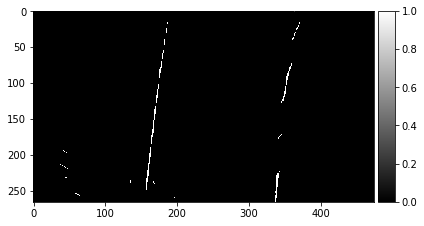

In [3]:
io.imshow(fig, cmap='gray')
plt.show()

In [4]:
def get_lanes_starting_points(img, returnHist=False):

    # Get the Histogram of the bottom half of the frame captured
    half_frame = img.shape[0] //2

    crop_half_frame = img[half_frame:, :]
    axis_Histogram = np.sum(crop_half_frame, axis = 0)
    midpoint = int(axis_Histogram.shape[0] / 2)
    
    # Get where is the max values located on the x-axis
    left_lane_x = np.argmax(axis_Histogram[:midpoint])
    right_lane_x = np.argmax(axis_Histogram[midpoint:]) + midpoint
    
    if returnHist:
        return left_lane_x, right_lane_x, axis_Histogram
    else:
        return left_lane_x, right_lane_x

In [5]:
left_x, right_x, hist = get_lanes_starting_points(fig, True)

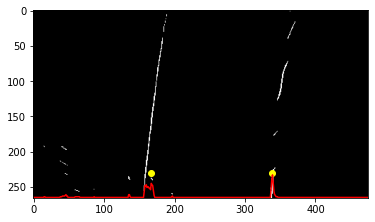

In [6]:
plt.imshow(fig, cmap='gray')
plt.plot(range(W), (H - 1 -  hist), color='red')  # H - 1- hist to make the plot at the bottom of the image
plt.scatter([left_x, right_x], [230, 230], color='yellow')
plt.show()

In [7]:
def sliding_window(img, imgHeight, left_lane_x, right_lane_x, window_height, window_width):
    
    # Arrays to hold the lane index
    left_lane_list = np.empty((0, 2))
    right_lane_list = np.empty((0, 2))
    
    # Creating the window on the lanes bases
    num_of_windows = imgHeight // window_height
    plt.imshow(img, cmap='gray')
    
    # Move the window on the lane
    for i in range(num_of_windows):
        y_start = imgHeight - window_height * (i + 1)
        y_end = imgHeight - window_height * i
        
        x_start_left = left_lane_x - window_width//2
        x_end_left = left_lane_x + window_width//2
        
        x_start_right = right_lane_x - window_width//2
        x_end_right = right_lane_x + window_width//2
                
        left_lane_win = img[y_start : y_end, x_start_left : x_end_left]
        right_lane_win = img[y_start : y_end, x_start_right : x_end_right]

        # get the white pixels in the left and right window
        left_white_pxls = np.argwhere(left_lane_win == 1)
        right_white_pxls = np.argwhere(right_lane_win == 1)

        # move from window coordinates to image coordinates
        left_white_pxls[:, 1] += (left_lane_x - window_width//2)
        left_white_pxls[:, 0] += y_start
        right_white_pxls[:,1] += (right_lane_x - window_width//2)
        right_white_pxls[:, 0] += y_start

        left_lane_list = np.vstack((left_lane_list, left_white_pxls))    
        right_lane_list = np.vstack((right_lane_list, right_white_pxls))    

        # update the window base
        if(len(left_white_pxls)):
            left_lane_x = int(np.mean(left_white_pxls[:, 1]))
        if(len(right_white_pxls)):
            right_lane_x = int(np.mean(right_white_pxls[:, 1]))
        
        plt.plot([x_start_left, x_start_left, x_end_left, x_end_left, x_start_left], 
                 [y_start, y_end - 1, y_end - 1, y_start, y_start], color='red')
        
        plt.plot([x_start_right, x_start_right, x_end_right, x_end_right, x_start_right], 
                 [y_start, y_end - 1, y_end - 1, y_start, y_start], color='red')
        

    # meter to pixel 
    meter_pixel = 30 / 720     # Assume 30 meters in 720 pixels

    # Curve fitting(2nd degree poynomial) for the points from the window
    left_curve_coeff = np.polyfit(left_lane_list[:, 0], left_lane_list[:, 1], 2)
    right_curve_coeff = np.polyfit(right_lane_list[:, 0], right_lane_list[:, 1], 2)

    return left_curve_coeff, right_curve_coeff
    

Wall time: 31.9 ms


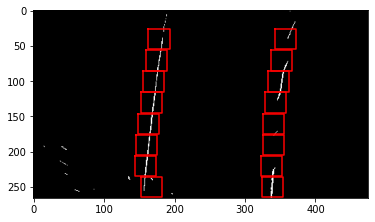

In [8]:
%time left_curve_coeff, right_curve_coeff = sliding_window(fig, H, left_x, right_x, 30, 30)

In [9]:
def generate_polynomial_values(coefficients, x_max):
    """
    Generate x and y values for a polynomial defined by its coefficients.

    Arguments:
    coefficients : array_like
        Coefficients of the polynomial.
    x_max : float
        Maximum value of x for generating values.

    Returns:
    x : ndarray
        Array of x values.
    y : ndarray
        Corresponding array of y values calculated from the polynomial function.
    """
    poly_function = np.poly1d(coefficients)
    
    # generate points from 0 to x max
    x = np.linspace(0, x_max, 100)
    
    # get corresponding y value
    y = poly_function(x)
    
    return x, y


In [10]:
x_left, y_left = generate_polynomial_values(left_curve_coeff, H - 1)
x_right, y_right = generate_polynomial_values(right_curve_coeff, H - 1)

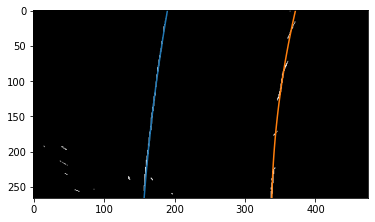

In [11]:
plt.imshow(fig, cmap='gray')
plt.plot(y_left, x_left)
plt.plot(y_right, x_right)
plt.show()

In [12]:
def calculate_curvature(a, b, x):
    numerator = np.abs(2 * a)
    denominator = (1 + (2 * a * x + b)**2) ** (3/2)
    curvature = numerator / denominator
    return curvature

In [13]:
def get_road_data(left_curve, right_curve, y_value):

    # polynomial fitting = Ax^2 + Bx + C
    a_left, b_left, _ = left_curve
    a_right, b_right, _ = right_curve

    # Radius of curvature = ((1 + (2Ax + B)**2)**(3/2)) / |2A|
    L_curvature = calculate_curvature(a_left, b_left, y_value)
    R_curvature = calculate_curvature(a_right, b_right, y_value)
    
    # If A = -ve , then the direction of curvature is at the left & vice-versa
    if min(L_curvature, R_curvature) > 1e-5:
        direction = 'right'
    elif min(L_curvature, R_curvature) < -1e-5:
        direction = 'left'
    else:
        direction = 'straight'
        
    return direction, L_curvature, R_curvature


In [15]:
get_road_data(left_curve_coeff, right_curve_coeff, H//2)

('right', 0.0003481775815554424, 0.0007533080141668611)

# Done!